Emily Hunt 2112325
---
04/12/2023

In [2]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
import matplotlib.pyplot as plt


In [3]:
wine_data = np.load('/content/wineData.npy')
wine_labels = np.load('/content/wineLabels.npy')

dataBounds =round(wine_data.shape[0] * 0.8)
trainingData = wine_data[:dataBounds]
testData = wine_data[dataBounds:]
trainingLabels = wine_labels[:dataBounds]
testLabels = wine_labels[dataBounds:]

FileNotFoundError: [Errno 2] No such file or directory: '/content/wineData.npy'

#Task 4.1

In [ ]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(trainingData,trainingLabels)
print(clf.score(testData,testLabels))

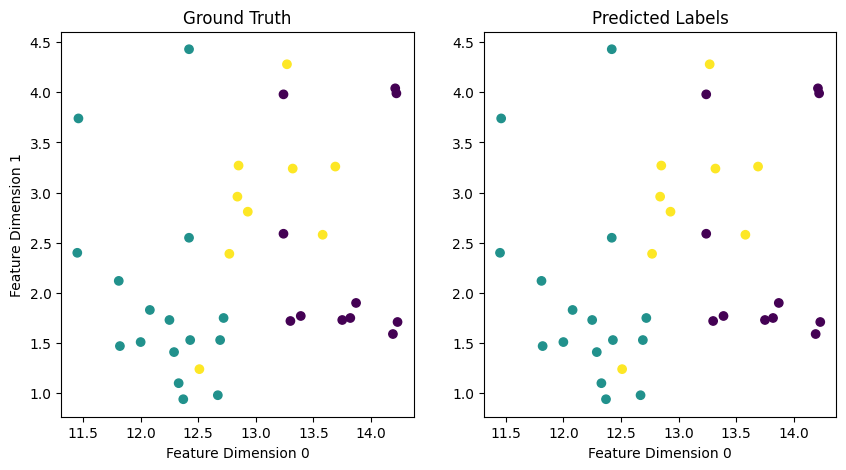

In [127]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.scatter(testData[:,0], testData[:,1], c=testLabels)
plt.ylabel('Feature Dimension 1')
plt.xlabel('Feature Dimension 0')
plt.title('Ground Truth')
plt.subplot(122)
plt.title('Predicted Labels')
plt.xlabel('Feature Dimension 0')
plt.scatter(testData[:,0], testData[:,1], c=clf.predict(testData))
plt.show()

#Task 4.2

In [128]:
## Normalise the data (helps with convergence)
normaliser = StandardScaler()
trainingData = normaliser.fit_transform(trainingData)
testData = normaliser.transform(testData)

In [4]:
model = tf.keras.Sequential(layers=[
    tf.keras.layers.Dense(4, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(len(np.unique(trainingLabels)), activation=tf.nn.softmax)])


NameError: name 'trainingLabels' is not defined

In [5]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

NameError: name 'model' is not defined

In [131]:
history = model.fit(trainingData, trainingLabels, epochs=150, validation_split=0.35, verbose=1)
model.summary()

Epoch 1/150
3/3 [==============================] - 3s 184ms/step - loss: 1.0690 - sparse_categorical_accuracy: 0.3696 - val_loss: 0.9914 - val_sparse_categorical_accuracy: 0.4600
Epoch 2/150
3/3 [==============================] - 0s 36ms/step - loss: 1.0580 - sparse_categorical_accuracy: 0.3913 - val_loss: 0.9827 - val_sparse_categorical_accuracy: 0.4600
Epoch 3/150
3/3 [==============================] - 0s 44ms/step - loss: 1.0476 - sparse_categorical_accuracy: 0.3913 - val_loss: 0.9742 - val_sparse_categorical_accuracy: 0.4600
Epoch 4/150
3/3 [==============================] - 0s 37ms/step - loss: 1.0378 - sparse_categorical_accuracy: 0.3804 - val_loss: 0.9660 - val_sparse_categorical_accuracy: 0.4400
Epoch 5/150
3/3 [==============================] - 0s 34ms/step - loss: 1.0283 - sparse_categorical_accuracy: 0.3913 - val_loss: 0.9580 - val_sparse_categorical_accuracy: 0.4400
Epoch 6/150
3/3 [==============================] - 0s 54ms/step - loss: 1.0188 - sparse_categorical_accuracy:

KeyboardInterrupt: ignored

In [ ]:
results = model.evaluate(testData, testLabels)
print(f'Test set loss: {results[0]:0.2f}, test set accuracy: {results[1]*100:0.2f}%')

plt.figure(figsize=[10,5])
plt.subplot(121)
plt.scatter(testData[:,0], testData[:,1], c=testLabels)
plt.ylabel('Feature Dimension 1')
plt.xlabel('Feature Dimension 0')
plt.title('Ground Truth')
plt.subplot(122)
plt.title('Predicted Labels')
plt.xlabel('Feature Dimension 0')
plt.scatter(testData[:,0], testData[:,1], c=np.argmax(model.predict(testData), axis=1))
plt.show()
print(np.argmax(model.predict(testData), axis=1))

In [ ]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')
plt.show()

#Task 4.3

In [ ]:
(trainingData, trainingLabels), (testData, testLabels) = tf.keras.datasets.mnist.load_data()

In [ ]:
trainingData = np.reshape(trainingData, (60000, 784))
testData = np.reshape(testData, (10000, 784))

normaliser = StandardScaler()
trainingData = normaliser.fit_transform(trainingData)
testData = normaliser.transform(testData)

In [ ]:
model = tf.keras.Sequential(layers=[
    tf.keras.layers.Dense(4, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
        tf.keras.layers.Dense(len(np.unique(trainingLabels)), activation=tf.nn.softmax)])



In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [ ]:
history = model.fit(trainingData, trainingLabels, epochs=20, validation_split=0.3, verbose=1)
model.summary()

In [ ]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')
plt.show()

In [ ]:
results = model.evaluate(testData, testLabels)
print(f'Test set loss: {results[0]:0.2f}, test set accuracy: {results[1]*100:0.2f}%')

Nodes 100:

0.35, 10
*  Test set loss: 0.57, test set accuracy: 83.40%
0.3, 20
*  Test set loss: 0.50, test set accuracy: 85.76%

Nodes to label:
*  Test set loss: 0.47, test set accuracy: 86.56%





# Task 4.4

In [8]:
(trainingData, trainingLabels1), (testData, testLabels1) = tf.keras.datasets.mnist.load_data()

trainingData1 = np.expand_dims(trainingData, axis = -1)/255
testData1 = np.expand_dims(testData, axis = -1)/255


#trainingLabels = tf.keras.utils.to_categorical(trainingLabels, len(np.unique(trainingLabels)))
#testLabels = tf.keras.utils.to_categorical(testLabels, len(np.unique(testLabels)))

print(trainingData.shape)

11490434/11490434 [==============================] - 3s 0us/step
(60000, 28, 28)


In [7]:
# # model = tf.keras.Sequential(layers=[
# #     tf.keras.layers.Dense(4, activation=tf.nn.relu),
# #     tf.keras.layers.Dense(10, activation=tf.nn.relu),
# #         tf.keras.layers.Conv2D(100, kernel_size = 3, activation=tf.nn.softmax)])

model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(4, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(10, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(len(np.unique(trainingLabels)), activation='relu'))


# model.summary()

# INPUT_SHAPE = (28, 28, 1)
# FILTER1_SIZE = 32
# FILTER2_SIZE = 64
# FILTER_SHAPE = (3, 3)
# POOL_SHAPE = (2, 2)
# FULLY_CONNECT_NUM = 128
# NUM_CLASSES = len(np.unique(trainingLabels))

# # Model architecture implementation
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Conv2D(FILTER1_SIZE, FILTER_SHAPE, activation='relu', input_shape=INPUT_SHAPE))
# model.add(tf.keras.layers.MaxPooling2D(POOL_SHAPE))
# model.add(tf.keras.layers.Conv2D(FILTER2_SIZE, FILTER_SHAPE, activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D(POOL_SHAPE))
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(FULLY_CONNECT_NUM, activation='relu'))
# model.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'))


NameError: name 'trainingLabels' is not defined

In [5]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
               loss=tf.keras.losses.CategoricalCrossentropy(),
               metrics=tf.keras.metrics.SparseCategoricalAccuracy())


In [6]:
history = model.fit(trainingData1, trainingLabels1, epochs=20, validation_split=0.2, verbose=1)

NameError: name 'model' is not defined

In [ ]:
results = model.evaluate(testData, testLabels)
print(f'Test set loss: {results[0]:0.2f}, test set accuracy: {results[1]*100:0.2f}%')
